<a href="https://colab.research.google.com/github/umairaziz719/SoundSense-Sentiment-Analysis/blob/main/Copy_of_soundsense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Required Libraries

In [30]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tensorflow.keras import backend as K
from IPython.display import Audio
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,LSTM, Dense, Dropout, BatchNormalization,Dense, GRU, Dropout, Activation, GRU
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import MaxNorm
import tensorflow.keras.layers as L
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')


In [33]:
!pip install librosa==0.9.2

##Loading Data

In [34]:
drive.mount('/content/drive')
!git clone https://github.com/umairaziz719/SoundSense-Sentiment-Analysis.git
paths = []
labels = []
dataset_path = '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data'
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        paths.append(file_path)
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Dataset is Loaded')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'SoundSense-Sentiment-Analysis' already exists and is not an empty directory.
Dataset is Loaded


In [35]:
len(paths)

2800

In [4]:
paths[:5]

['/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/OAF_angry/OAF_raise_angry.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/OAF_angry/OAF_tape_angry.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/OAF_angry/OAF_pole_angry.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/OAF_angry/OAF_mess_angry.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/OAF_angry/OAF_home_angry.wav']

In [5]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

##Exploratory Analysis

In [6]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/SoundSense-Sentiment-Analysis/TESS To...,angry
1,/content/SoundSense-Sentiment-Analysis/TESS To...,angry
2,/content/SoundSense-Sentiment-Analysis/TESS To...,angry
3,/content/SoundSense-Sentiment-Analysis/TESS To...,angry
4,/content/SoundSense-Sentiment-Analysis/TESS To...,angry


In [7]:
print("Data Types of DataFrame Columns:")
print(df.dtypes)

Data Types of DataFrame Columns:
speech    object
label     object
dtype: object


In [8]:
df['label'].value_counts()

label
angry      400
neutral    400
sad        400
disgust    400
ps         400
fear       400
happy      400
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

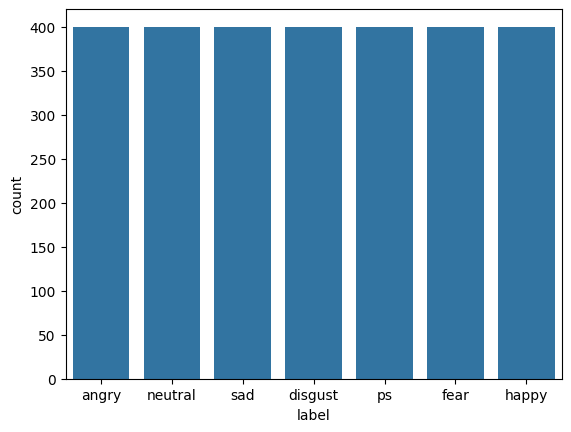

In [9]:
sns.countplot(data=df, x='label')

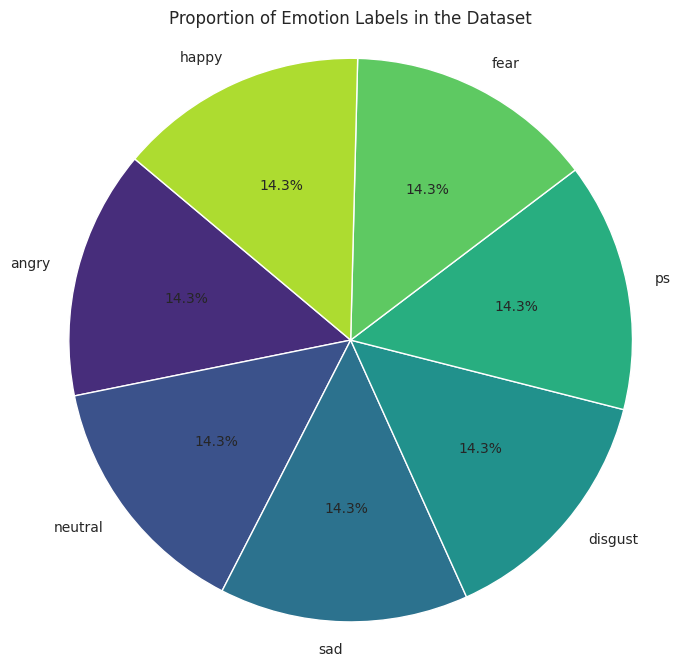

In [10]:
label_counts = df['label'].value_counts()
labels = label_counts.index
counts = label_counts.values
colors = sns.color_palette('viridis', len(labels))
sns.set_style("whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Proportion of Emotion Labels in the Dataset')
plt.axis('equal')
plt.show()

In [11]:
def plot_with_title(emotion, title, figsize=(10, 4), size=20):
    plt.figure(figsize=figsize)
    plt.title(f"{emotion}: {title}", fontsize=size, fontweight='bold', color='navy')

def waveplot(data, sr, emotion):
    plot_with_title(emotion, "Waveform")
    librosa.display.waveshow(data, sr=sr, color='dodgerblue', alpha=0.8, linewidth=1.5)
    plt.xlabel('Time (s)', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('Amplitude', fontsize=15, fontweight='bold', color='darkslategray')
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.show()

def mfcc(data, sr, emotion):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plot_with_title(emotion, "MFCCs", figsize=(10, 6))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.xlabel('Time (s)', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('MFCC Coefficients', fontsize=15, fontweight='bold', color='darkslategray')
    plt.tight_layout()
    plt.show()

def zero_crossing_rate(data, sr, emotion):
    zcr = librosa.feature.zero_crossing_rate(y=data)
    plot_with_title(emotion, "Zero Crossing Rate", figsize=(10, 4))
    plt.plot(zcr[0], color='crimson')
    plt.xlabel('Frame', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('ZCR', fontsize=15, fontweight='bold', color='darkslategray')
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.show()


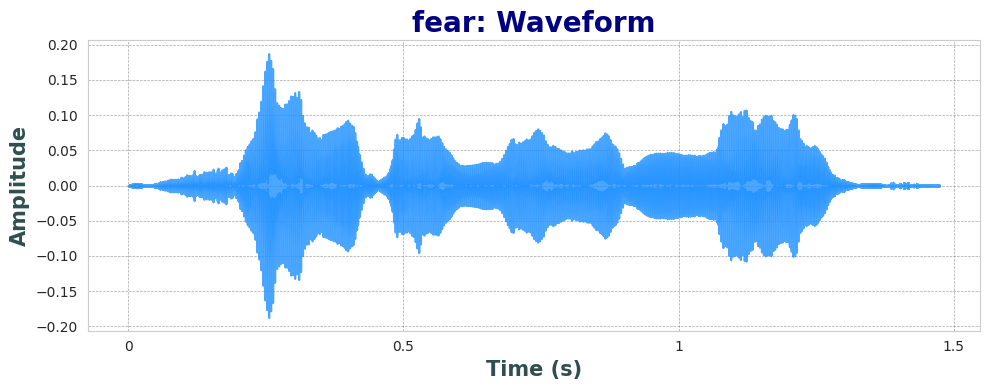

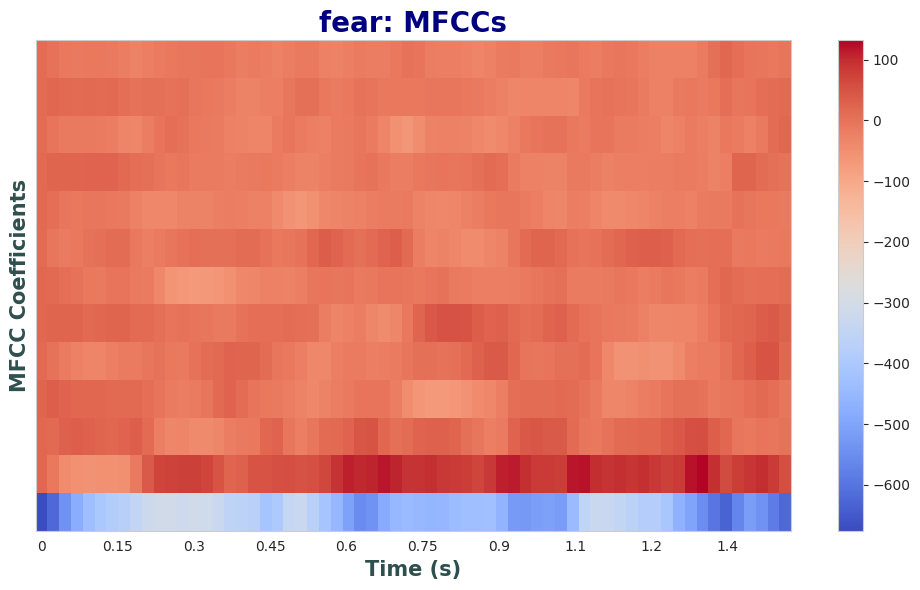

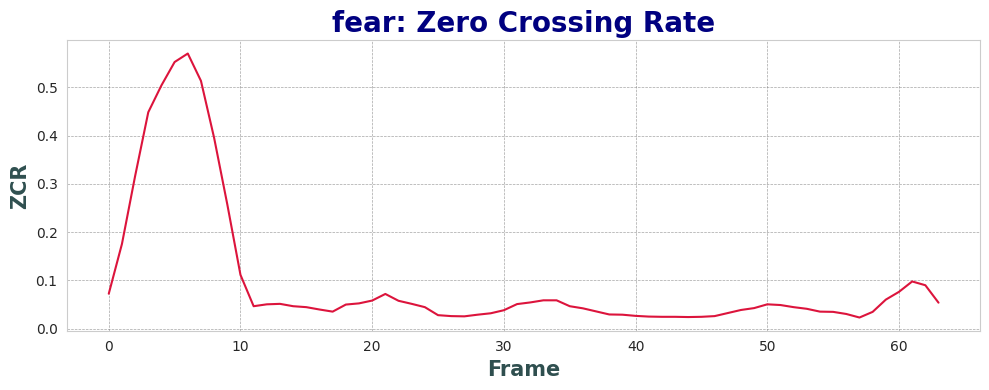

In [12]:
emotion = 'fear'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
mfcc(data, sampling_rate, emotion)
zero_crossing_rate(data, sampling_rate, emotion)
Audio(path)

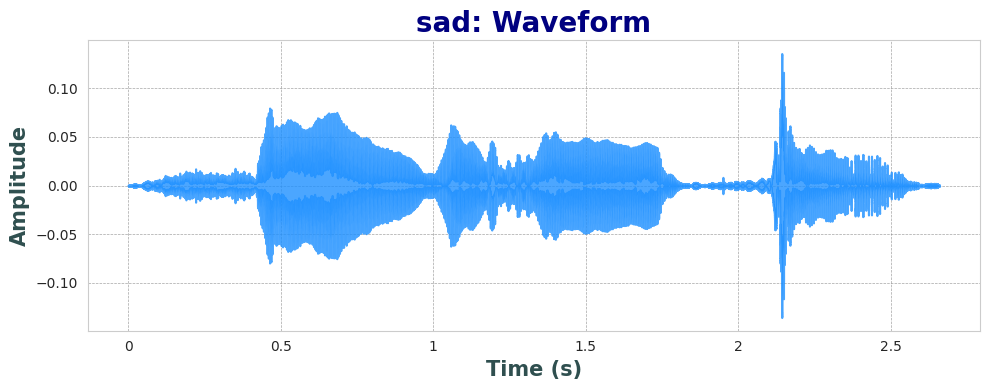

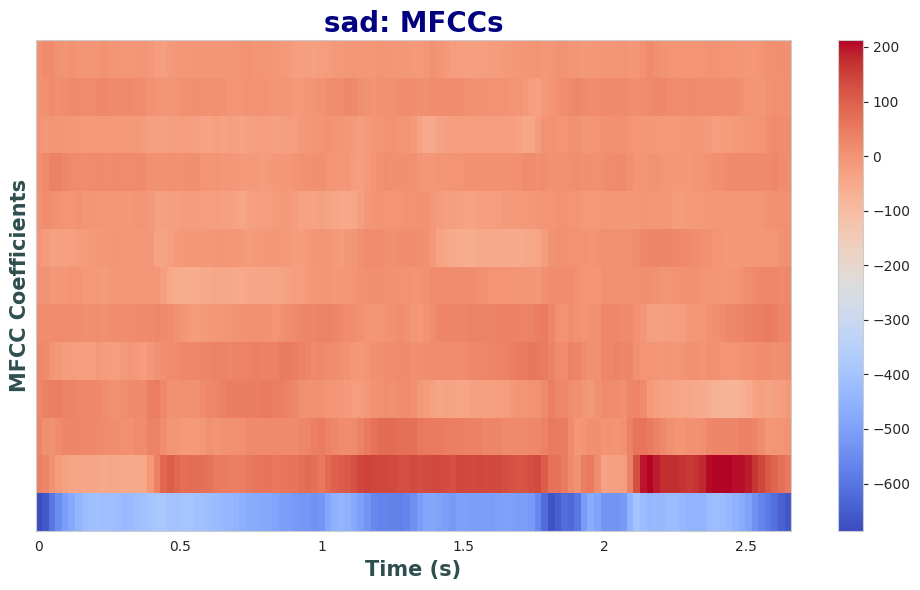

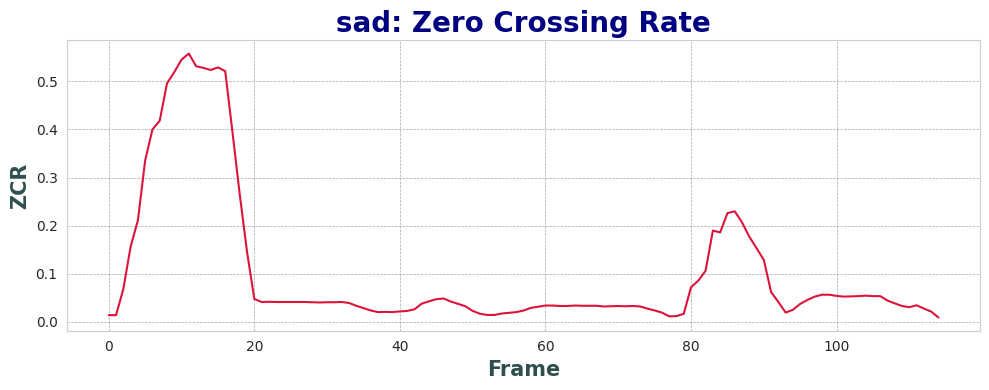

In [13]:
emotion = 'sad'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
mfcc(data, sampling_rate, emotion)
zero_crossing_rate(data, sampling_rate, emotion)
Audio(path)

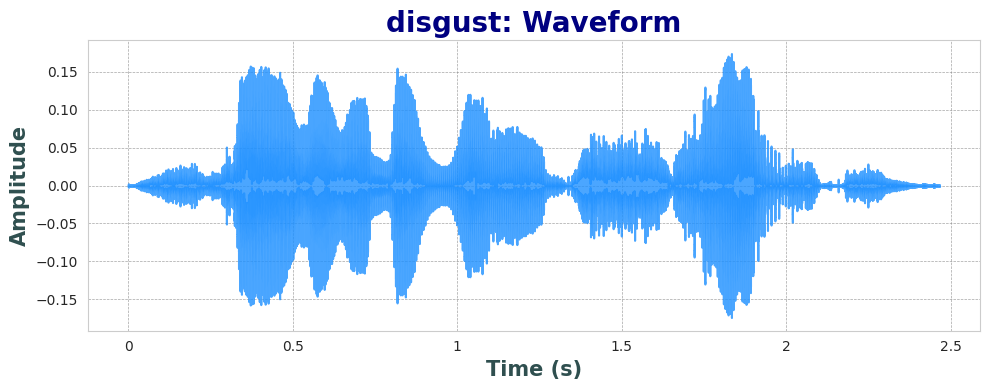

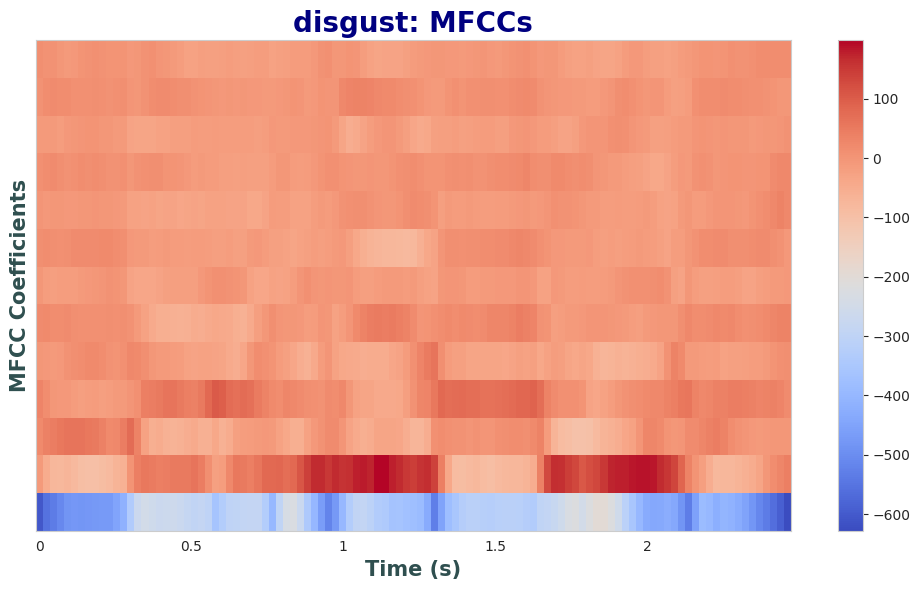

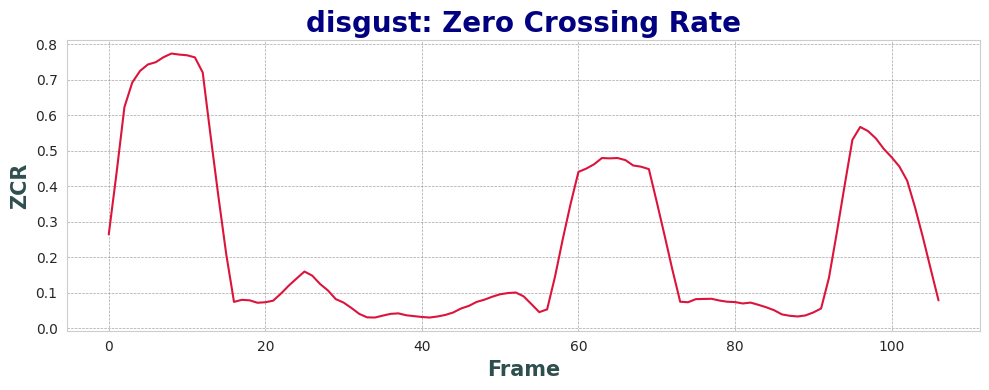

In [14]:
emotion = 'disgust'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
mfcc(data, sampling_rate, emotion)
zero_crossing_rate(data, sampling_rate, emotion)
Audio(path)

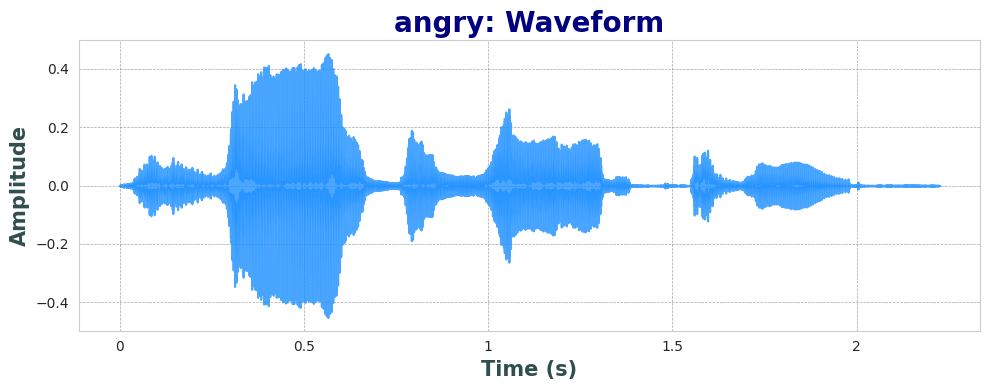

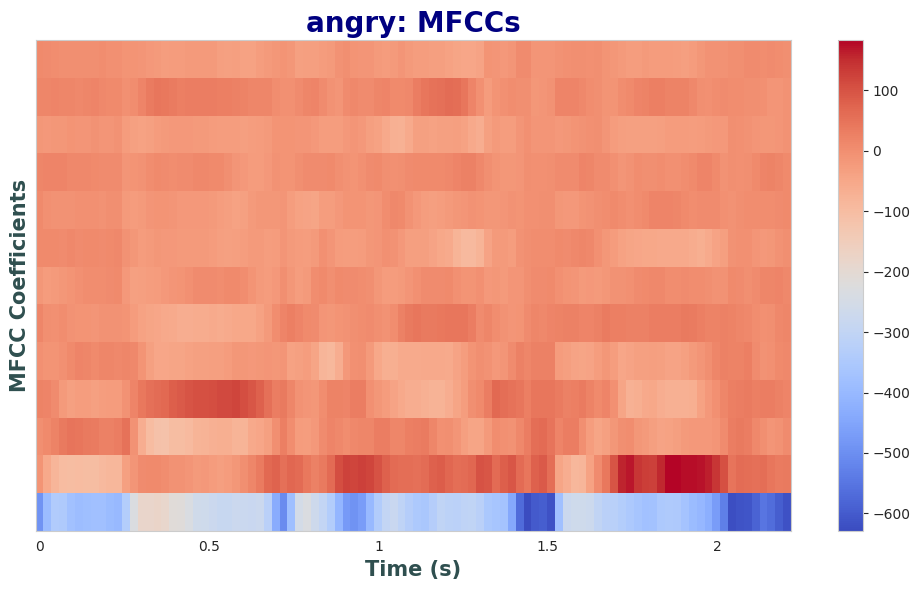

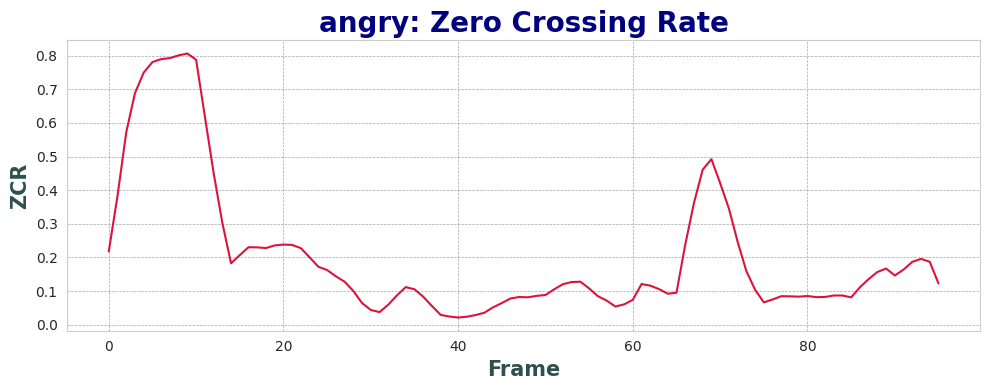

In [15]:
emotion = 'angry'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
mfcc(data, sampling_rate, emotion)
zero_crossing_rate(data, sampling_rate, emotion)
Audio(path)

##Data Agumentation Functions

In [13]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])

    return data
def stretch_process(data,rate=0.8):

    return librosa.effects.time_stretch(data,rate)
def shift_process(data):
    shift_range = int(np.random.uniform(low=-5,high=5) * 1000)

    return np.roll(data,shift_range)
def pitch_process(data,sampling_rate,pitch_factor=0.7):

    return librosa.effects.pitch_shift(data,sampling_rate,pitch_factor)

In [14]:
def extract_process(data,sample_rate):

    output_result = np.array([])
    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T,axis=0)
    output_result = np.hstack((output_result,mean_zero))

    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T,axis=0)
    output_result = np.hstack((output_result,root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mel_spectogram))

    return output_result

In [15]:
def export_process(path):

    data,sample_rate = librosa.load(path,duration=2.5,offset=0.6)

    output_1 = extract_process(data,sample_rate)
    result = np.array(output_1)

    noise_out = add_noise(data)
    output_2 = extract_process(noise_out,sample_rate)
    result = np.vstack((result,output_2))

    new_out = stretch_process(data)
    strectch_pitch = pitch_process(new_out,sample_rate)
    output_3 = extract_process(strectch_pitch,sample_rate)
    result = np.vstack((result,output_3))

    return result

In [16]:
x_Train, y_Train = [],[]

for path,emotion in zip(df['speech'],df['label']):

    features = export_process(path)

    for element in features:
        x_Train.append(element)
        y_Train.append(emotion)

In [17]:
print(len(x_Train))
print(len(y_Train))
print(len(df['speech']))

8400
8400
2800


In [18]:
data = pd.DataFrame(x_Train)
data["speech"] = y_Train

In [19]:
data.head(-1)

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,speech
0,0.069455,0.626076,0.508997,0.299135,0.240091,0.377761,0.404211,0.323462,0.407576,0.418168,...,0.000254,0.000218,0.000248,0.000114,0.000071,0.000039,0.000006,4.929415e-07,7.247674e-09,angry
1,0.098069,0.640806,0.646921,0.422974,0.335222,0.412859,0.482991,0.364676,0.420573,0.459367,...,0.000350,0.000315,0.000363,0.000195,0.000165,0.000132,0.000106,9.137631e-05,1.005460e-04,angry
2,0.100865,0.608657,0.653532,0.411219,0.237640,0.308604,0.498142,0.373182,0.367122,0.410313,...,0.000123,0.000083,0.000053,0.000065,0.000056,0.000009,0.000002,1.380282e-07,6.281847e-10,angry
3,0.057856,0.481713,0.458083,0.461424,0.449162,0.428644,0.481614,0.457739,0.406940,0.411138,...,0.000172,0.000134,0.000200,0.000061,0.000040,0.000026,0.000021,2.689413e-06,9.533126e-08,angry
4,0.175366,0.647557,0.565270,0.545631,0.529397,0.528500,0.508933,0.484817,0.463928,0.477284,...,0.000530,0.000470,0.000506,0.000387,0.000326,0.000348,0.000370,3.393859e-04,3.354675e-04,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8394,0.140898,0.385888,0.445211,0.443174,0.523789,0.490007,0.369580,0.347175,0.435841,0.412134,...,0.011767,0.007770,0.004418,0.002770,0.002673,0.001085,0.000149,1.583100e-05,1.109490e-06,happy
8395,0.169930,0.446472,0.503984,0.509229,0.600809,0.522975,0.414417,0.408603,0.480060,0.431299,...,0.015389,0.011288,0.007255,0.006018,0.005819,0.004344,0.003550,3.259487e-03,3.517961e-03,happy
8396,0.166557,0.438334,0.474457,0.541707,0.561692,0.574498,0.425759,0.367977,0.445996,0.492983,...,0.001993,0.003074,0.002203,0.001110,0.000613,0.000379,0.000148,5.490985e-06,4.412900e-07,happy
8397,0.115595,0.525501,0.554219,0.660216,0.522884,0.454536,0.448387,0.454465,0.463451,0.461116,...,0.010757,0.005111,0.002477,0.002476,0.003886,0.001014,0.000213,2.609728e-05,7.005808e-06,happy


In [20]:
print(data["speech"].value_counts())

speech
angry      1200
neutral    1200
sad        1200
disgust    1200
ps         1200
fear       1200
happy      1200
Name: count, dtype: int64


##Preprocessing

In [21]:
X = data.iloc[:,:-1].values
Y = data["speech"].values

In [22]:
encoder = OneHotEncoder()
scaler_data = StandardScaler()

In [23]:
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X,Y,train_size=0.8,random_state=42,shuffle=True)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(6720, 162) (1680, 162) (6720, 7) (1680, 7)


In [25]:
X_train = scaler_data.fit_transform(X_train)
X_val = scaler_data.transform(X_val)

In [26]:
X_train = np.expand_dims(X_train,axis=2)
X_val = np.expand_dims(X_val,axis=2)

##CNN Model

In [28]:
model = tf.keras.Sequential([
    L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1),
             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.3),

    L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu',
             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.3),

    L.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu',
             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.3),

    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu',
             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.3),

    L.Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu',
             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),
    L.Dropout(0.3),

    L.Flatten(),
    L.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.BatchNormalization(),
    L.Dropout(0.5),
    L.Dense(7, activation='softmax')
])
optimizer = Adam(learning_rate=0.0015)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 batch_normalization (Batch  (None, 162, 256)          1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 81, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 batch_normalization_1 (Bat  (None, 81, 256)           1

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
105/105 [==============================] - 58s 520ms/step - loss: 10.0920 - accuracy: 0.4571 - val_loss: 9.0114 - val_accuracy: 0.2292 - lr: 0.0015
Epoch 2/50
105/105 [==============================] - 57s 542ms/step - loss: 6.0702 - accuracy: 0.7573 - val_loss: 6.5114 - val_accuracy: 0.1625 - lr: 0.0015
Epoch 3/50
105/105 [==============================] - 54s 515ms/step - loss: 3.7722 - accuracy: 0.8487 - val_loss: 4.6289 - val_accuracy: 0.2357 - lr: 0.0015
Epoch 4/50
105/105 [==============================] - 60s 568ms/step - loss: 2.5061 - accuracy: 0.8799 - val_loss: 3.5194 - val_accuracy: 0.3470 - lr: 0.0015
Epoch 5/50
105/105 [==============================] - 55s 518ms/step - loss: 1.8563 - accuracy: 0.8914 - val_loss: 2.4918 - val_accuracy: 0.5381 - lr: 0.0015
Epoch 6/50
105/105 [==============================] - 56s 538ms/step - loss: 1.4851 - accuracy: 0.9009 - val_loss: 1.7467 - val_accuracy: 0.7619 - lr: 0.0015
Epoch 7/50
105/105 [==============================]

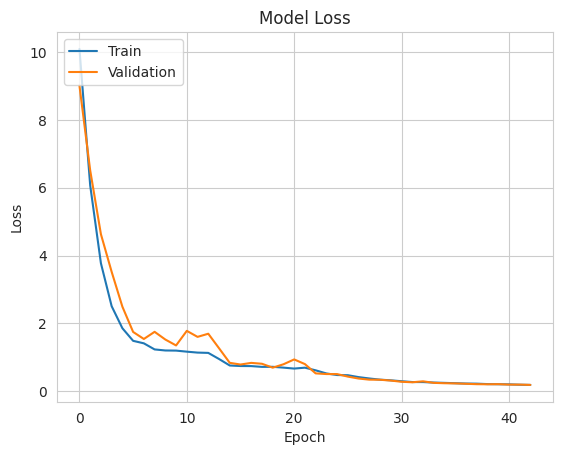

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
sample_size = 10
y_pred = model.predict(X_val[:sample_size])

# Convert predictions back from one-hot encoding
y_pred_labels = encoder.inverse_transform(y_pred)
y_val_labels = encoder.inverse_transform(y_val[:sample_size])

# Print predictions and actual values
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_labels.flatten()
df['Actual Labels'] = y_val_labels.flatten()
df

1/1 [==============================] - 0s 451ms/step


,Predicted Labels,Actual Labels
0,sad,sad
1,fear,fear
2,fear,fear
3,fear,fear
4,neutral,neutral
5,disgust,disgust
6,angry,angry
7,angry,angry
8,fear,fear
9,sad,sad


In [ ]:
confusion_matrix = confusion_matrix(y_val_labels,y_pred_labels)

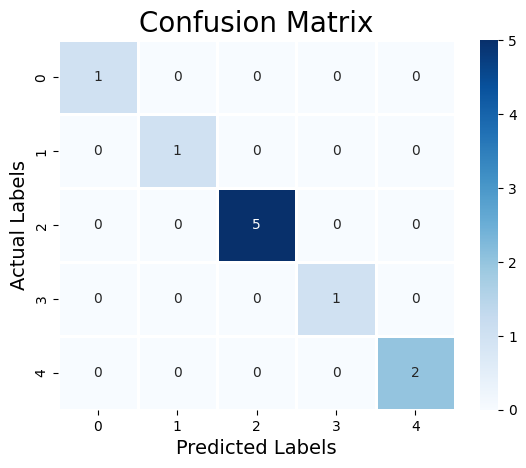

In [ ]:
sns.heatmap(confusion_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

##LSTM model

In [ ]:
# Define the model architecture
model1 = Sequential([
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01), kernel_constraint=MaxNorm(3), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0015623413249850273)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 162, 64)           16896     
                                                                 
 batch_normalization (Batch  (None, 162, 64)           256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 162, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 162, 64)           33024     
                                                                 
 batch_normalization_1 (Bat  (None, 162, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 162, 64)           0

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.00001, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
# Train the model
history1 = model1.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_scheduler, model_checkpoint])

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 4.8075 - accuracy: 0.1915
Epoch 1: val_accuracy improved from -inf to 0.16250, saving model to best_model.h5
53/53 [==============================] - 58s 924ms/step - loss: 4.8075 - accuracy: 0.1915 - val_loss: 4.1007 - val_accuracy: 0.1625 - lr: 0.0016
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 3.8186 - accuracy: 0.2263
Epoch 2: val_accuracy improved from 0.16250 to 0.18690, saving model to best_model.h5
53/53 [==============================] - 44s 834ms/step - loss: 3.8186 - accuracy: 0.2263 - val_loss: 3.4449 - val_accuracy: 0.1869 - lr: 0.0016
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 3.2035 - accuracy: 0.2504
Epoch 3: val_accuracy improved from 0.18690 to 0.19107, saving model to best_model.h5
53/53 [==============================] - 47s 889ms/step - loss: 3.2035 - accuracy: 0.2504 - val_loss: 3.0068 - val_accuracy: 0.1911 - lr: 0.0016
Epoch 4/50
53/53 [==========

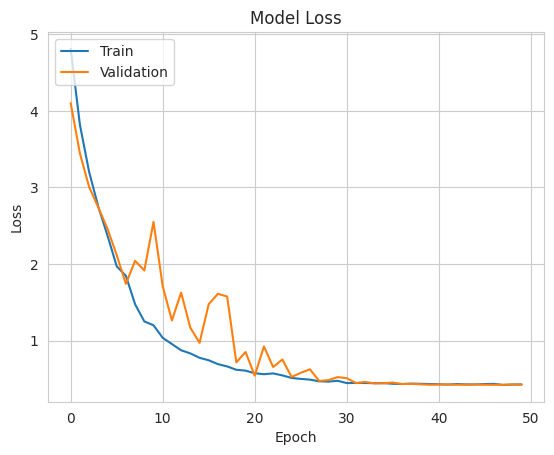

In [ ]:
# Example plotting training history
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
sample_size = 10
y_pred = model1.predict(X_val[:sample_size])

# Convert predictions back from one-hot encoding
y_pred_labels = encoder.inverse_transform(y_pred)
y_val_labels = encoder.inverse_transform(y_val[:sample_size])

# Print predictions and actual values
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_labels.flatten()
df['Actual Labels'] = y_val_labels.flatten()
df

1/1 [==============================] - 1s 1s/step


,Predicted Labels,Actual Labels
0,sad,sad
1,fear,fear
2,fear,fear
3,fear,fear
4,neutral,neutral
5,disgust,disgust
6,angry,angry
7,angry,angry
8,fear,fear
9,sad,sad


In [ ]:
confusion_matrix = confusion_matrix(y_val_labels,y_pred_labels)

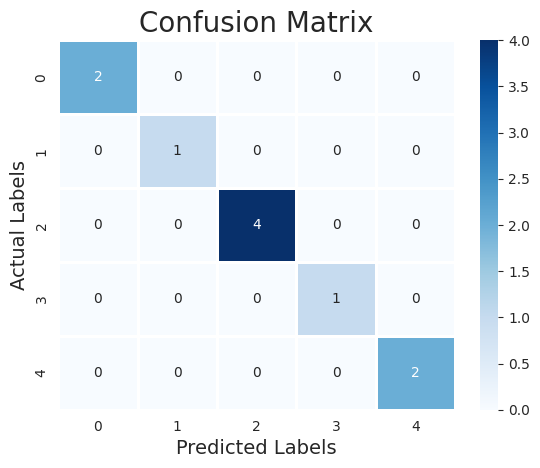

In [ ]:
sns.heatmap(confusion_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

##GRU Model

In [76]:
# Define the GRU model architecture
model2 = Sequential([
    GRU(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),

    GRU(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),

    GRU(64, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model2.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_27 (GRU)                (None, 162, 256)          198912    
                                                                 
 batch_normalization_36 (Ba  (None, 162, 256)          1024      
 tchNormalization)                                               
                                                                 
 dropout_36 (Dropout)        (None, 162, 256)          0         
                                                                 
 gru_28 (GRU)                (None, 162, 128)          148224    
                                                                 
 batch_normalization_37 (Ba  (None, 162, 128)          512       
 tchNormalization)                                               
                                                                 
 dropout_37 (Dropout)        (None, 162, 128)         

In [77]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    verbose=1,
    patience=5,
    min_lr=0.00001
)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

##Finding Optimize learning rate

In [74]:
class LearningRateFinder(Callback):
    def __init__(self, min_lr=1e-6, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}

    def on_train_begin(self, logs=None):
        self.lr_mult = (self.max_lr / self.min_lr) ** (1 / self.total_iterations)
        K.set_value(self.model.optimizer.lr, self.min_lr)

    def on_batch_end(self, batch, logs=None):
        self.iteration += 1
        lr = K.get_value(self.model.optimizer.lr)
        self.history.setdefault('lr', []).append(lr)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)
        if self.iteration >= self.total_iterations:
            self.model.stop_training = True

    def plot_lr(self):
        plt.plot(self.history['lr'])
        plt.xlabel('Iteration')
        plt.ylabel('Learning Rate')
        plt.show()

    def plot_loss(self):
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.show()


In [75]:
learning_rates = [
    1e-6, 5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4,
    1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1
]
results = []
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    # Compile the model with the current learning rate
    model2.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=1)

    # Record the final validation loss and accuracy
    final_val_loss = history.history['val_loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    results.append((lr, final_val_loss, final_val_accuracy))



Training with learning rate: 1e-06
Epoch 1/10
105/105 [==============================] - 14s 42ms/step - loss: 8.8959 - accuracy: 0.1472 - val_loss: 7.7000 - val_accuracy: 0.1101
Epoch 2/10
105/105 [==============================] - 3s 31ms/step - loss: 8.9194 - accuracy: 0.1432 - val_loss: 7.7200 - val_accuracy: 0.1274
Epoch 3/10
105/105 [==============================] - 3s 31ms/step - loss: 8.8761 - accuracy: 0.1454 - val_loss: 7.7604 - val_accuracy: 0.1149
Epoch 4/10
105/105 [==============================] - 3s 33ms/step - loss: 8.8848 - accuracy: 0.1426 - val_loss: 7.7844 - val_accuracy: 0.1304
Epoch 5/10
105/105 [==============================] - 4s 36ms/step - loss: 8.8583 - accuracy: 0.1479 - val_loss: 7.7824 - val_accuracy: 0.1351
Epoch 6/10
105/105 [==============================] - 4s 38ms/step - loss: 8.8499 - accuracy: 0.1484 - val_loss: 7.7668 - val_accuracy: 0.1345
Epoch 7/10
105/105 [==============================] - 4s 37ms/step - loss: 8.8106 - accuracy: 0.1521 - va

In [ ]:
# Sort results by validation loss
results.sort(key=lambda x: x[1])

print("Learning rate results (sorted by validation loss):")
for lr, val_loss, val_accuracy in results:
    print(f"Learning rate: {lr}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Select the best learning rate (lowest validation loss)
best_lr = results[0][0]
print(f"Best learning rate: {best_lr}")


In [78]:
#Training the model,
history2 = model2.fit(X_train, y_train,epochs = 50,validation_data=(X_val, y_val), batch_size = 64, shuffle = True,callbacks=[early_stopping, lr_scheduler, model_checkpoint])

Epoch 1/50
104/105 [============================>.] - ETA: 0s - loss: 6.9598 - accuracy: 0.1696
Epoch 1: val_accuracy improved from -inf to 0.15417, saving model to best_model.h5
105/105 [==============================] - 11s 42ms/step - loss: 6.9468 - accuracy: 0.1693 - val_loss: 5.2671 - val_accuracy: 0.1542 - lr: 0.0010
Epoch 2/50
105/105 [==============================] - ETA: 0s - loss: 5.0380 - accuracy: 0.1893
Epoch 2: val_accuracy did not improve from 0.15417
105/105 [==============================] - 3s 30ms/step - loss: 5.0380 - accuracy: 0.1893 - val_loss: 4.3416 - val_accuracy: 0.1542 - lr: 0.0010
Epoch 3/50
105/105 [==============================] - ETA: 0s - loss: 4.1330 - accuracy: 0.1859
Epoch 3: val_accuracy improved from 0.15417 to 0.16369, saving model to best_model.h5
105/105 [==============================] - 3s 31ms/step - loss: 4.1330 - accuracy: 0.1859 - val_loss: 3.6720 - val_accuracy: 0.1637 - lr: 0.0010
Epoch 4/50
105/105 [==============================] - ET

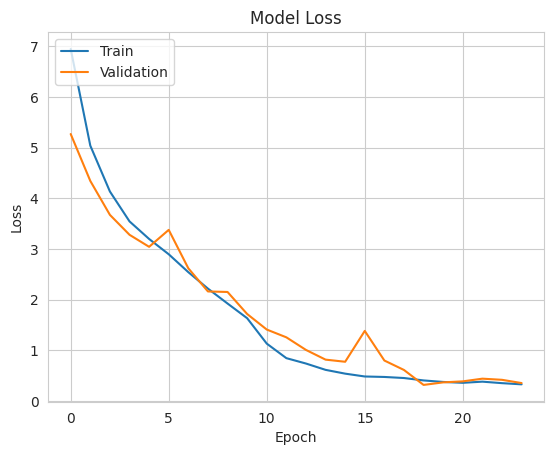

In [79]:
# Example plotting training history
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [80]:
sample_size = 100
y_pred = model2.predict(X_val[:sample_size])

# Convert predictions back from one-hot encoding
y_pred_labels = encoder.inverse_transform(y_pred)
y_val_labels = encoder.inverse_transform(y_val[:sample_size])

# Print predictions and actual values
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_labels.flatten()
df['Actual Labels'] = y_val_labels.flatten()
df

4/4 [==============================] - 1s 15ms/step


,Predicted Labels,Actual Labels
0,angry,angry
1,happy,happy
2,happy,happy
3,ps,ps
4,fear,fear
...,...,...
95,sad,sad
96,sad,sad
97,ps,ps
98,disgust,disgust


In [81]:
confusion_matrix = confusion_matrix(y_val_labels,y_pred_labels)

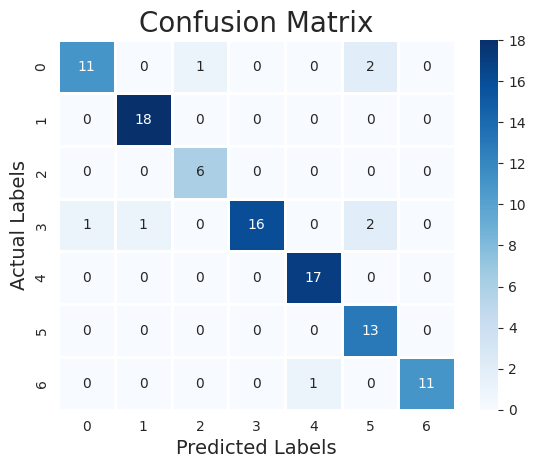

In [82]:
sns.heatmap(confusion_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [89]:
x_train, x_test, y_train, y_test = train_test_split(x_Train, y_Train, test_size=0.2, random_state=42)

##SVM MODEL

In [90]:
# Create and train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(x_train, y_train)

SVC(kernel='linear', random_state=42)

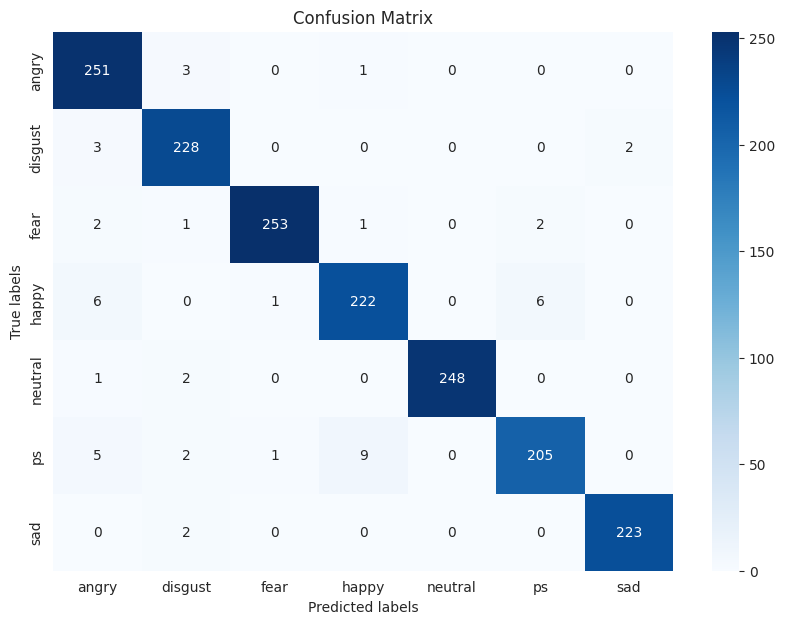

In [95]:
from sklearn.metrics import classification_report, confusion_matrix
# Evaluate the model
y_pred = svm_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_Train))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_Train), yticklabels=np.unique(y_Train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()